## Python + SQL.
 с помощью pandahouse выгрузить нужные данные из ClickHouse и проанализируем их в python.

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

In [2]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Задание 1
Вывод количества строк в таблице ldn_listings.

In [3]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [5]:
query = """
SELECT count(*)
FROM ldn_listings
"""
int(ph.execute(query, connection=connection))

85207

# Задание 2
Выгрузить  из таблицы данные о цене в зависимости от типа жилья

- price – цена за ночь
- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

**Hint:** replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] 

чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

Сгруппировать полученный датафрейм по типу жилья и посчитать 75-й перцентиль цены.



In [6]:
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM ldn_listings
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


In [7]:
df.groupby('room_type').price.quantile(q=0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

### ответ:
Private room: 70.00

# Задание 3
К данным о цене и типе комнаты дополнительно выгрузить данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

**Hint:** toFloat32OrNull(столбец)

Построить график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [8]:
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
       toFloat32OrNull(review_scores_rating) as review_scores_rating
FROM ldn_listings
WHERE review_scores_rating is not NULL
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [11]:
df_1 = df.groupby('room_type', as_index=False).agg({'price' : 'mean', 'review_scores_rating' : 'mean'})
df_1

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


In [12]:
df_1 = df_1.rename(columns={"price": "price_mean", "review_scores_rating": "rating_mean"})


In [13]:
df_1

,room_type,price_mean,rating_mean
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


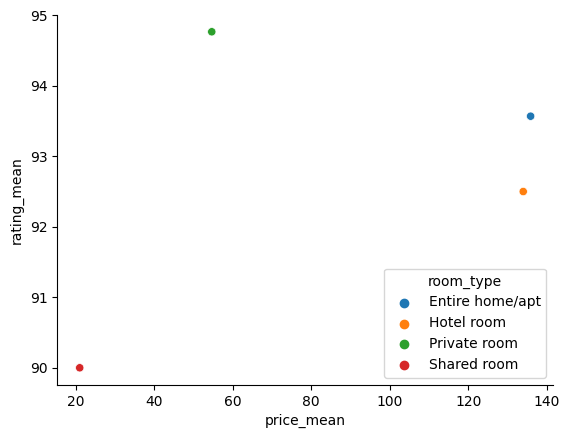

In [15]:
sns.scatterplot(data=df_1, x="price_mean", y="rating_mean", hue="room_type")
sns.despine()

# Задание 4


Проверить, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

- host_id – идентификатор хозяина (уникальный)
- host_verifications – какими способами хост подтвердил свой профиль

Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 

"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [16]:
query = """
SELECT DISTINCT host_id as uniq_host,
       host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df_2 = ph.read_clickhouse(query, connection=connection)
df_2.head()

,uniq_host,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [17]:
df_2.host_verifications = df_2.host_verifications.apply(lambda x: x.strip(']').strip('[').replace('\'', '').split(', '))
df_2 = df_2.explode('host_verifications')
df_2.head()

,uniq_host,host_verifications
0,54730,email
0,54730,phone
0,54730,facebook
0,54730,reviews
0,54730,offline_government_id


In [18]:
df_2.host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

**Ответ:** 34

# Задание 5
Определить количество объявлений и в каких районах хозяева указали впечатления.
Визуализировать результат с помощью тепловой карты.

In [19]:
query  = """
SELECT
    COUNT(experiences_offered) as experience_count,
    experiences_offered,
    neighbourhood_cleansed
FROM
    ldn_listings
WHERE
    experiences_offered !='none'
GROUP BY 
    neighbourhood_cleansed,
    experiences_offered
LIMIT 100
    """
df_3 = ph.read_clickhouse(query, connection=connection)
df_3.head()

,experience_count,experiences_offered,neighbourhood_cleansed
0,1,family,Harrow
1,21,family,Brent
2,32,family,Kensington and Chelsea
3,44,family,Islington
4,21,family,Haringey


In [20]:
df_type = df_3.groupby(['neighbourhood_cleansed', 'experiences_offered'], as_index=False) \
                    .agg({'experience_count' : 'sum'}) \
                    .sort_values('experience_count', ascending=False)

In [21]:
pivot_df = df_type.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experience_count') \
                       .fillna(0).head(100)

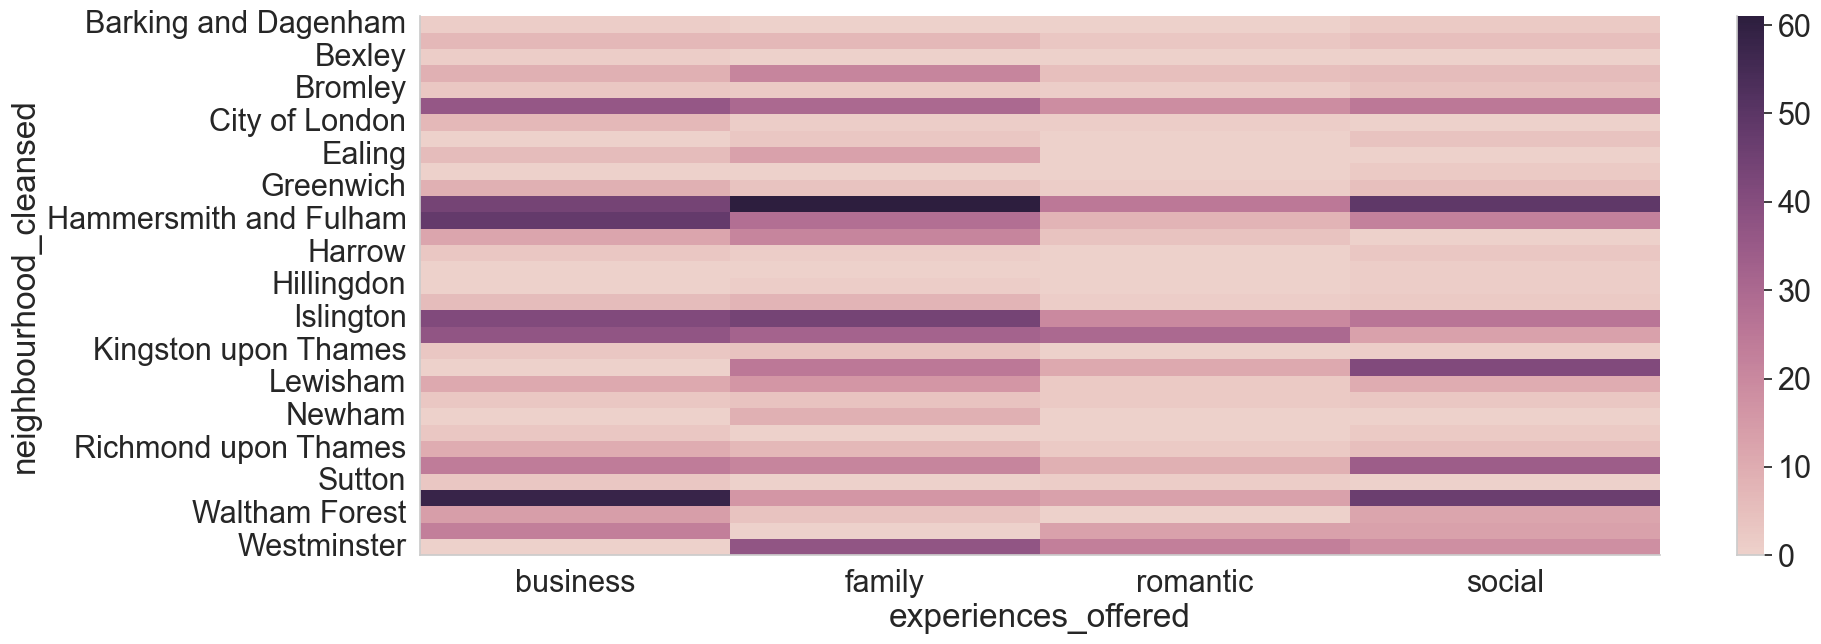

In [22]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
       )
cmap=sns.cubehelix_palette(as_cmap=True)
sns.heatmap(pivot_df, cmap=cmap)
sns.despine()

# Задание 6
Выгрузить данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:
Визуализировать: 
- исходные распределения цен для каждого типа жилья


In [29]:
query  = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM
    ldn_listings
WHERE
    experiences_offered !='none'
    """
room_type = ph.read_clickhouse(query, connection=connection)
room_type.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


In [25]:
room_type.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

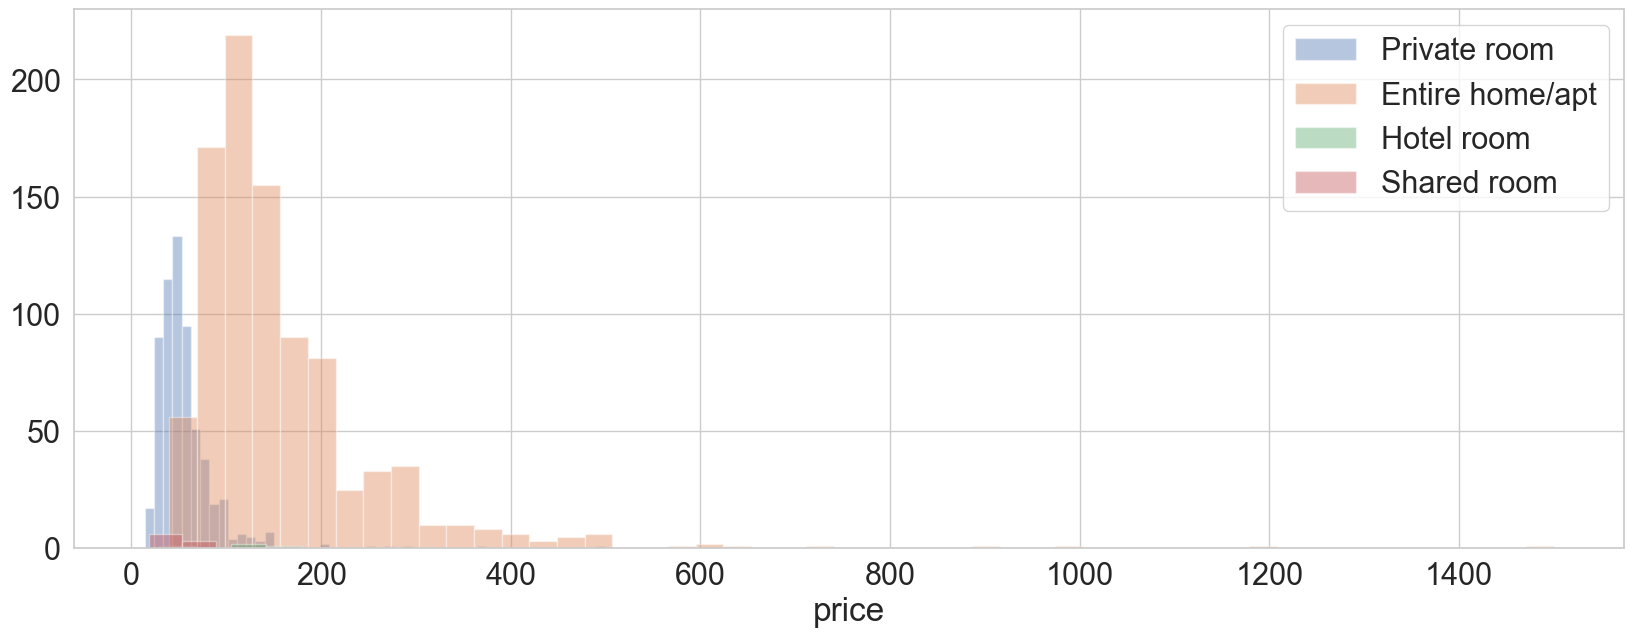

In [27]:
sns.distplot(room_type.query("room_type == 'Private room'").price, kde=False, label='Private room')
sns.distplot(room_type.query("room_type == 'Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(room_type.query("room_type == 'Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(room_type.query("room_type == 'Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

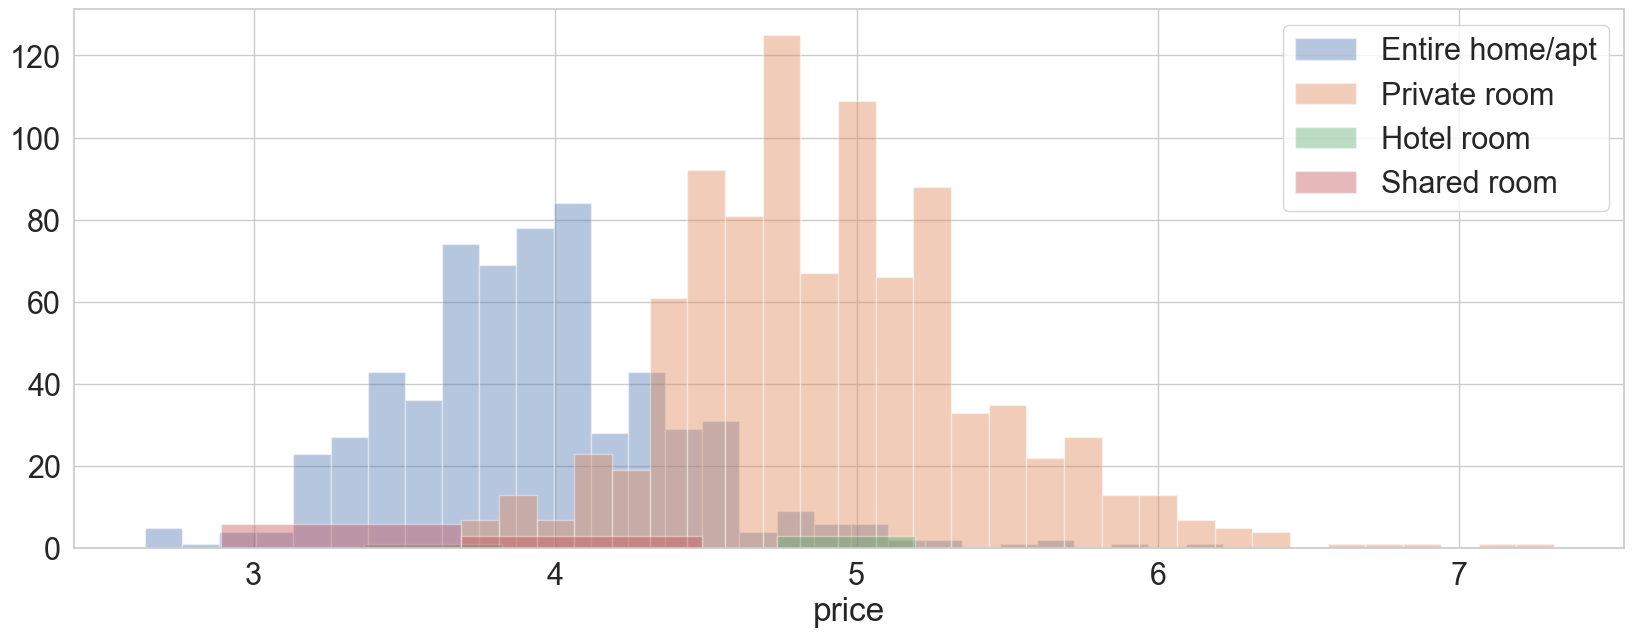

In [30]:
sns.distplot(np.log(room_type.query("room_type == 'Private room'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(room_type.query("room_type == 'Entire home/apt'").price), kde=False, label='Private room')
sns.distplot(np.log(room_type.query("room_type == 'Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(room_type.query("room_type == 'Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

# Задание 7
Выгрузить данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

Построить график динамики средних цен на жилье в зависимости от типа комнаты по годам . 

In [39]:
query  = """
SELECT  
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    first_review
FROM ldn_listings 
WHERE 
    first_review > '2010-01-01'
LIMIT 1000
    """
df_7 = ph.read_clickhouse(query, connection=connection)
df_7.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [40]:
df_7.dtypes

room_type        object
price           float32
first_review     object
dtype: object

In [41]:
df_7['first_review'] = pd.to_datetime(df_7['first_review'])
df_7.dtypes

room_type               object
price                  float32
first_review    datetime64[ns]
dtype: object

In [42]:
df_7['year'] = df_7['first_review'].dt.year

In [43]:
df_7.head()

,room_type,price,first_review,year
0,Private room,65.0,2010-08-18,2010
1,Entire home/apt,300.0,2011-03-21,2011
2,Entire home/apt,65.0,2016-03-05,2016
3,Private room,29.0,2010-04-14,2010
4,Private room,100.0,2010-10-16,2010


In [44]:
df_7 = df_7.loc[:, ['room_type', 'price', 'year']]

In [45]:
df_7.head()

,room_type,price,year
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010


In [49]:
mean_prices = df_7.groupby(['room_type', 'year'], as_index=False).agg({'price' : 'mean'})

In [52]:
mean_prices = mean_prices.rename(columns={'price': 'avg_price'})
mean_prices.head()

,room_type,year,avg_price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328


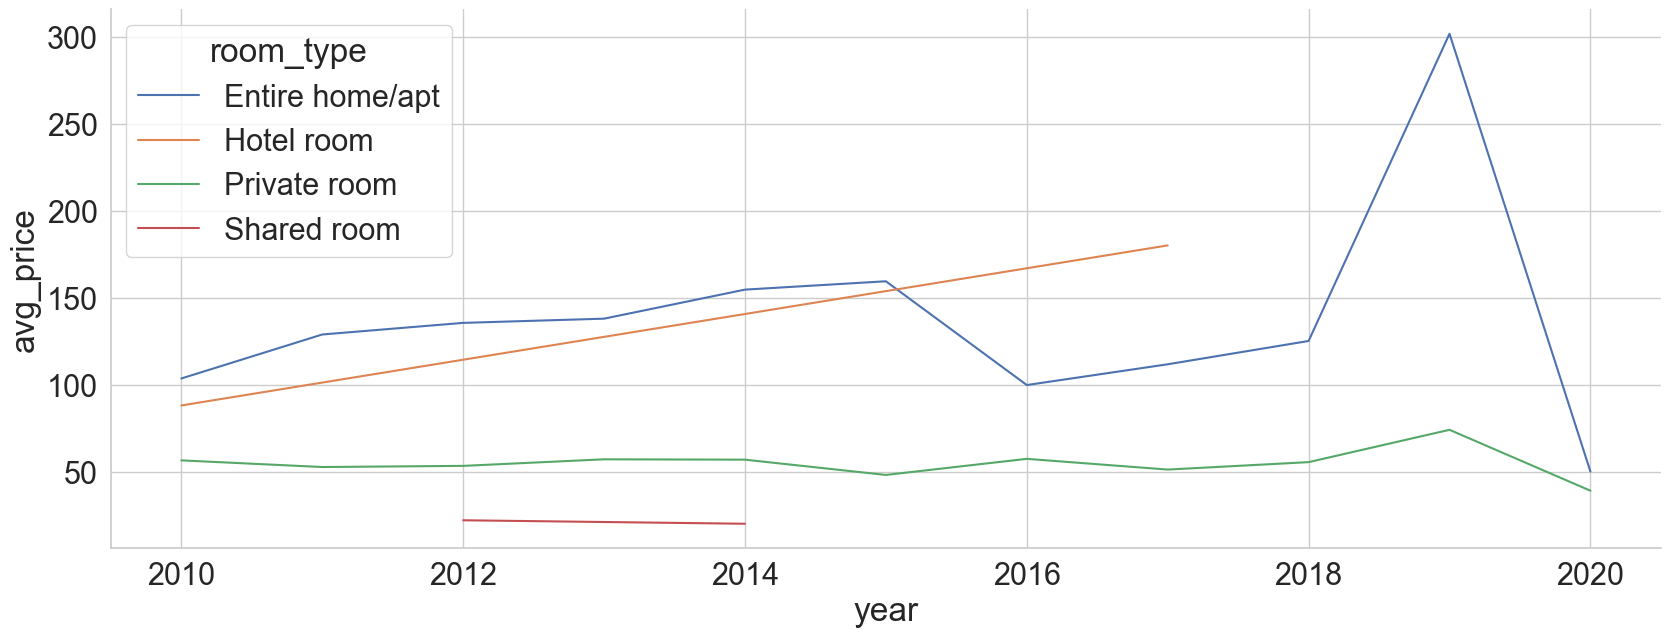

In [53]:
sns.lineplot(x='year', y='avg_price', hue='room_type', data=mean_prices)
sns.despine()